In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from microjax.engine import value_and_grad, relu
from microjax.nn import MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

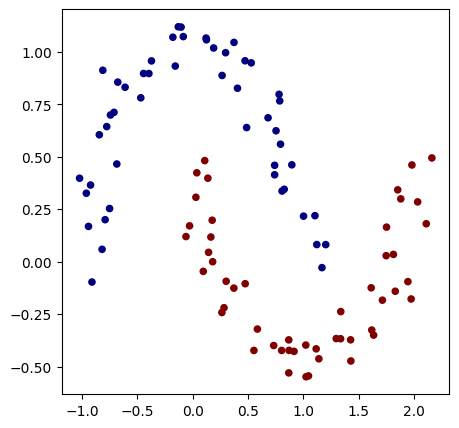

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model (which is just a pure function)
nin = 2
nouts = [16, 16, 1]
model = MLP.init(nin, nouts) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [6]:
# check export and import model
params = model.parameters()
model_copy = MLP.from_parameters(params, nin, nouts)
print(model_copy)
assert params == model_copy.parameters()
assert model == model_copy

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]


In [ ]:
# define loss as a function of model parameters
def loss(*params):
    model = MLP.from_parameters(params, nin, nouts)
    
    # forward the model to get input scores
    scores = list(map(model, X))
    
    # svm "max-margin" loss
    losses = [relu(1 + -yi*scorei) for yi, scorei in zip(y, scores)]
    data_loss = sum(losses) * (1 / len(losses))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum(p*p for p in params)
    
    total_loss = data_loss + reg_loss
    
    return total_loss
    
def accuracy(params):
    model = MLP.from_parameters(params, nin, nouts)
    
    # forward the model to get input scores
    scores = list(map(model, X)) 
    
    accuracy = [(yi > 0) == (scorei.value > 0) for yi, scorei in zip(y, scores)]
    return sum(accuracy) / len(accuracy)

total_loss = loss(*params)
acc = accuracy(params)
print(total_loss, acc)

<[Tracer: value=0.8958441028683222, parents=[np.float64(0.8862514464368222), 0.009592656431500013], op=Primitive(name=add)]> 0.5


In [14]:
# optimization

for k in range(100):
    acc = accuracy(params)
    total_loss, grad = value_and_grad(loss)(*params)
    
    # update (gd)
    learning_rate = 1.0 - 0.9*k/100
    for i, _ in enumerate(params):
        params[i] -= learning_rate * grad[i]
        
    if k%1 == 0:
        print(f"step {k} loss {total_loss}, accuracy {acc*100}%")
    


step 0 loss 0.31354548191852194, accuracy 86.0%
step 1 loss 0.2809730876185898, accuracy 89.0%
step 2 loss 0.26509803952726685, accuracy 91.0%
step 3 loss 0.2626263353808374, accuracy 91.0%
step 4 loss 0.27507871951056023, accuracy 91.0%
step 5 loss 0.2599943559100698, accuracy 90.0%
step 6 loss 0.24500337887819426, accuracy 92.0%
step 7 loss 0.22339927682551633, accuracy 92.0%
step 8 loss 0.2242043330103917, accuracy 93.0%
step 9 loss 0.20525367668683597, accuracy 91.0%
step 10 loss 0.2415114264749203, accuracy 93.0%
step 11 loss 0.20218056545939012, accuracy 92.0%
step 12 loss 0.21310257218168946, accuracy 93.0%
step 13 loss 0.15252761667363157, accuracy 95.0%
step 14 loss 0.17008910395854634, accuracy 95.0%
step 15 loss 0.18150985579300039, accuracy 93.0%
step 16 loss 0.23383537140676733, accuracy 92.0%
step 17 loss 0.16262437164298474, accuracy 93.0%
step 18 loss 0.12648111830188377, accuracy 95.0%
step 19 loss 0.12563314708771744, accuracy 95.0%
step 20 loss 0.17714578164353637, a

(-1.548639298268643, 1.951360701731357)

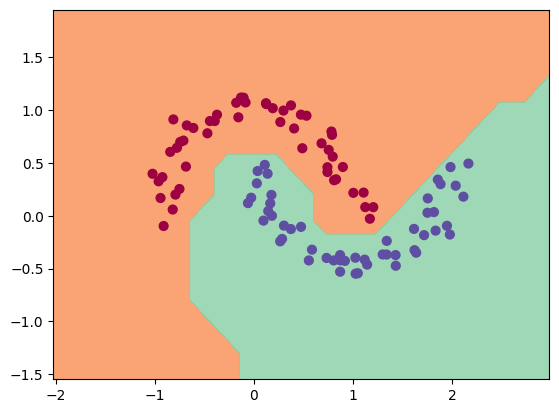

In [ ]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

# rebuild model
model = MLP.from_parameters(params, nin, nouts)
    
# forward the model to get input scores
scores = list(map(model, Xmesh))

Z = np.array([s.value > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())